In [1]:
from azure.ai.ml import MLClient

from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

try:
    credential = DefaultAzureCredential()
except Exception as ex:
    credential = InteractiveBrowserCredential()

In [2]:
ml_client =  MLClient.from_config(credential=credential, path="./config.json")

Found the config file in: /config.json


In [4]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

web_path = "https://azurestorageacc8304.blob.core.windows.net/azurestoragecontainer/UI/2023-08-15_045656_UTC/iris.csv"

iris_data = Data(
    name="iris_dataset",
    path=web_path,
    type=AssetTypes.URI_FILE,
    description="Dataset for iris cars species",
    tags={"source_type": "web", "source": "AzureML examples blob"},
    version="1.0.0",
)

In [5]:
iris_data = ml_client.data.create_or_update(iris_data)
print(
    f"Dataset with name {iris_data.name} was registered to workspace, the dataset version is {iris_data.version}"
)

Dataset with name iris_dataset was registered to workspace, the dataset version is 1.0.0


In [6]:
import os

dependencies_dir = "./dependencies"
os.makedirs(dependencies_dir, exist_ok=True)

In [7]:
%%writefile {dependencies_dir}/conda.yaml
name: model-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - numpy=1.21.2
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pandas>=1.1,<1.2
  - pip:
    - inference-schema[numpy-support]==1.3.0
    - xlrd==2.0.1
    - azureml-mlflow==1.42.0

Writing ./dependencies/conda.yaml


In [8]:
from azure.ai.ml.entities import Environment

custom_env_name = "irisdataenv"

pipeline_job_env = Environment(
    name=custom_env_name,
    description="Custom environment for iris species pipeline",
    tags={"scikit-learn": "0.24.2"},
    conda_file=os.path.join(dependencies_dir, "conda.yaml"),
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
    version="0.1.1",
)
pipeline_job_env = ml_client.environments.create_or_update(pipeline_job_env)

print(
    f"Environment with name {pipeline_job_env.name} is registered to workspace, the environment version is {pipeline_job_env.version}"
)

Environment with name irisdataenv is registered to workspace, the environment version is 0.1.1


In [9]:
import os

train_src_dir = "./src"
os.makedirs(train_src_dir, exist_ok=True)

In [10]:
%%writefile {train_src_dir}/main.py
import os
import argparse
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--n_estimators", required=False, default=100, type=int)
    parser.add_argument("--learning_rate", required=False, default=0.1, type=float)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    args = parser.parse_args()
   
    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    ###################
    #<prepare the data>
    ###################
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    print("input data:", args.data)
    
    iris_df = pd.read_csv(args.data, header=0, index_col=0)

    mlflow.log_metric("num_samples", iris_df.shape[0])
    mlflow.log_metric("num_features", iris_df.shape[1] - 1)

    train_df, test_df = train_test_split(
        iris_df,
        test_size=args.test_train_ratio,
    )
    ####################
    #</prepare the data>
    ####################

    ##################
    #<train the model>
    ##################
    # Extracting the label column
    y_train = train_df.pop("species")

    # convert the dataframe values to array
    X_train = train_df.values

    # Extracting the label column
    y_test = test_df.pop("species")

    # convert the dataframe values to array
    X_test = test_df.values

    print(f"Training with data of shape {X_train.shape}")

    clf = GradientBoostingClassifier(
        n_estimators=args.n_estimators, learning_rate=args.learning_rate
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    ###################
    #</train the model>
    ###################

    ##########################
    #<save and register model>
    ##########################
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=clf,
        registered_model_name=args.registered_model_name,
        artifact_path=args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=clf,
        path=os.path.join(args.registered_model_name, "trained_model"),
    )
    ###########################
    #</save and register model>
    ###########################
    
    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()

Writing ./src/main.py


In [11]:
from azure.ai.ml import command
from azure.ai.ml import Input

registered_model_name = "iris_species_model"

job = command(
    inputs=dict(
        data=Input(type=AssetTypes.URI_FILE, path=iris_data.path),
        test_train_ratio=0.2,
        learning_rate=0.25,
        registered_model_name=registered_model_name,
    ),
    code="./src/",  # location of source code
    command="python main.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} --learning_rate ${{inputs.learning_rate}} --registered_model_name ${{inputs.registered_model_name}}",
    environment="irisdataenv@latest",
    experiment_name="exp_iris",
    display_name="iris_species_prediction",
)

In [12]:
ml_client.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading src (0.0 MBs): 100%|████████

Experiment,Name,Type,Status,Details Page
exp_iris,teal_glove_s9gb8w25sx,command,Starting,Link to Azure Machine Learning studio


In [13]:
import uuid

# Creating a unique name for the endpoint
online_endpoint_name = "iris-ep-" + str(uuid.uuid4())[:8]

In [14]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is an online endpoint",
    auth_mode="key",
    tags={
        "training_dataset": "iris_species",
        "model_type": "sklearn.GradientBoostingClassifier",
    },
)

endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()

print(f"Endpoint {endpoint.name} provisioning state: {endpoint.provisioning_state}")

Endpoint iris-ep-70bc60c3 provisioning state: Succeeded


In [15]:
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

print(
    f'Endpoint "{endpoint.name}" with provisioning state "{endpoint.provisioning_state}" is retrieved'
)

Endpoint "iris-ep-70bc60c3" with provisioning state "Succeeded" is retrieved


In [16]:
latest_model_version = max(
    [int(m.version) for m in ml_client.models.list(name=registered_model_name)]
)

In [18]:
model = ml_client.models.get(name=registered_model_name, version=latest_model_version)


# create an online deployment.
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_DS1_v2",
    instance_count=1,
)

blue_deployment = ml_client.begin_create_or_update(blue_deployment).result()

Instance type Standard_DS1_v2 may be too small for compute resources. Minimum recommended compute SKU is Standard_DS3_v2 for general purpose endpoints. Learn more about SKUs here: https://learn.microsoft.com/en-us/azure/machine-learning/referencemanaged-online-endpoints-vm-sku-list
Check: endpoint iris-ep-70bc60c3 exists


.....................................................................

HttpResponseError: (None) OutOfQuota: Container terminated due to insufficient memory. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-outofquota
Code: None
Message: OutOfQuota: Container terminated due to insufficient memory. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-outofquota
Exception Details:	(None) OutOfQuota: Container terminated due to insufficient memory. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-outofquota
	The build log is available in the workspace blob store "azuremldev5177923440" under the path "/azureml/ImageLogs/f933f149-bc11-45e8-9dd3-b80d56ef23bd/build.log"
	Code: None
	Message: OutOfQuota: Container terminated due to insufficient memory. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-outofquota
	The build log is available in the workspace blob store "azuremldev5177923440" under the path "/azureml/ImageLogs/f933f149-bc11-45e8-9dd3-b80d56ef23bd/build.log"

# Unable to Interact with the model

- ## Due to Out of Quota : Standard_DS1_v2
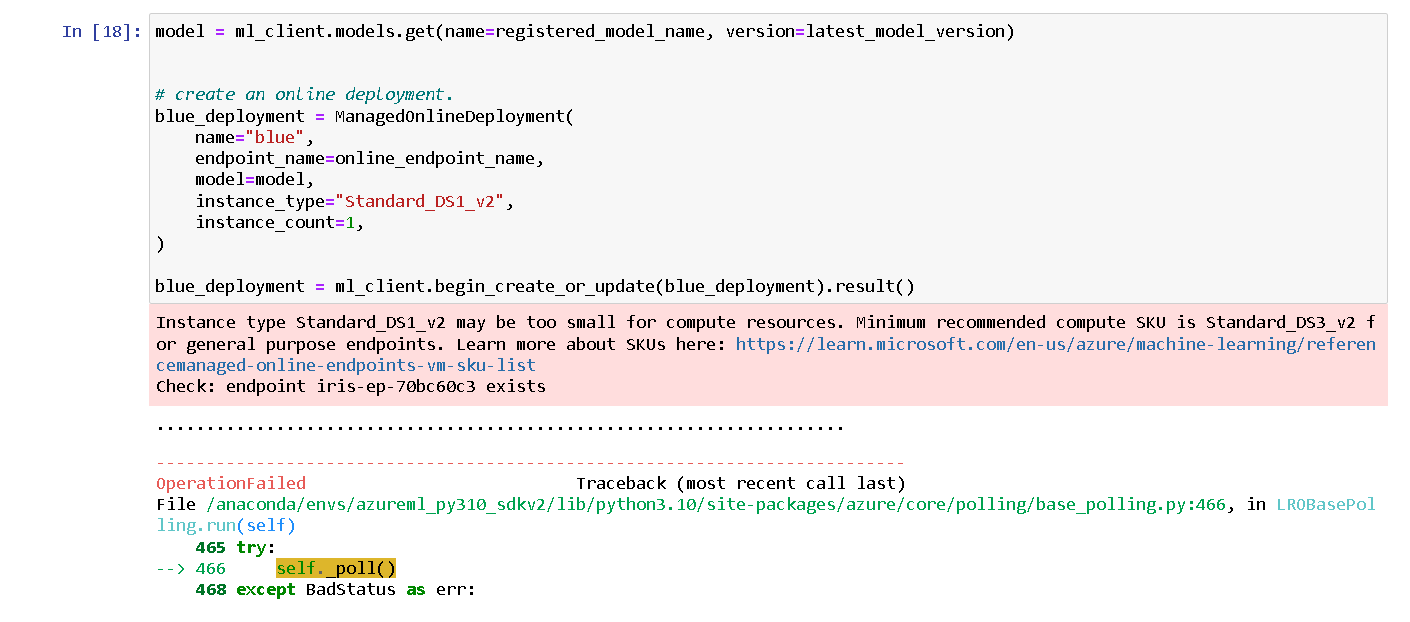

- ## Due to student subscription - Standard_DS1_v2
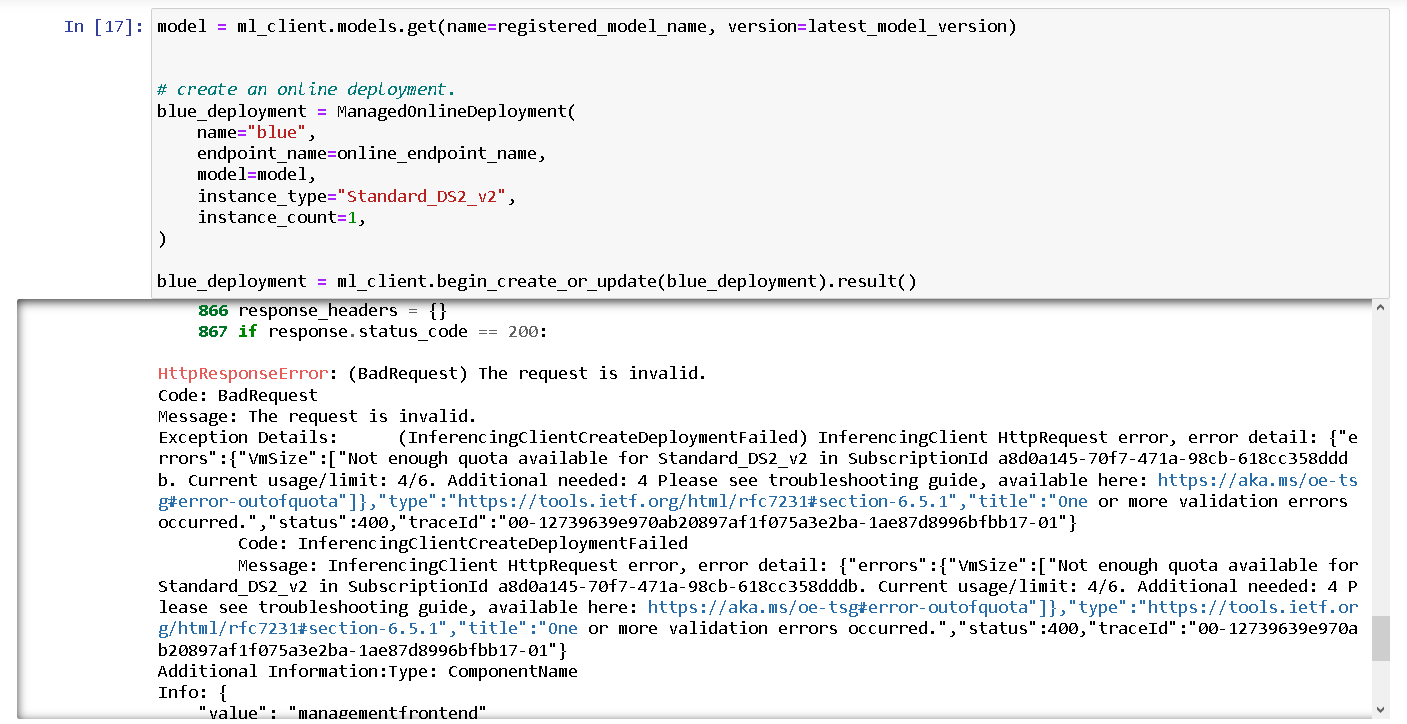

I am in azure for students subscription in which the instance_type i can use is Standard_DS1_v2 but due to out of quota on this type I am unable to interact with the model and if I switch to the Standard_DS2_v2 then I am getting service unavailable error. All I have to switch for pay-as-you-go subscription which is not good for me as a student. 

Hope, you will understand the case ...


In [19]:
deploy_dir = "./deploy"
os.makedirs(deploy_dir, exist_ok=True)

In [20]:
%%writefile {deploy_dir}/sample-request.json
{
  "input_data": {
    "columns": [0,1,2,3],
    "index": [0, 1],
    "data": [
            [4.6,3.5,1.5,2.6],
            [7.3,4.2,5.1,4.5]
        ]
  }
}

Writing ./deploy/sample-request.json


In [21]:
ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    request_file="./deploy/sample-request.json",
    deployment_name="blue",
)

ServiceResponseError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))